In [3]:
import sys
import numpy as np
import matplotlib.pyplot as plt
sys.path.append("/home/jmdeloui/BRANCHWP1/STL_dev/STL_main")

from STL_2D_Kernel_Torch import STL_2D_Kernel_Torch as STLDataClass
from STL_Healpix_Kernel_Torch import STL_Healpix_Kernel_Torch as STLH
from ST_Operator import ST_Operator as SO

target=np.random.randn(1,1,12*32**2)
DC=STLH(target)
st_op=SO(DC)
r=st_op.apply(DC,norm='auto')
r2=st_op.apply(DC,norm='S2_ref')

Normalization of ScatCov statistics
Using self S2 for normalization


Exception: Data expected with dg=0

/home/jmdeloui/BRANCHWP1/STL_dev/STL_main/ST_Statistics.py:402: RuntimeWarning: Mean of empty slice
  S3_jj = np.nanmean(np.nanmean(S3_mag, axis=-1), axis=-1)  # (J, J)
/home/jmdeloui/BRANCHWP1/STL_dev/STL_main/ST_Statistics.py:424: RuntimeWarning: Mean of empty slice
  S4_jj = np.nanmean(


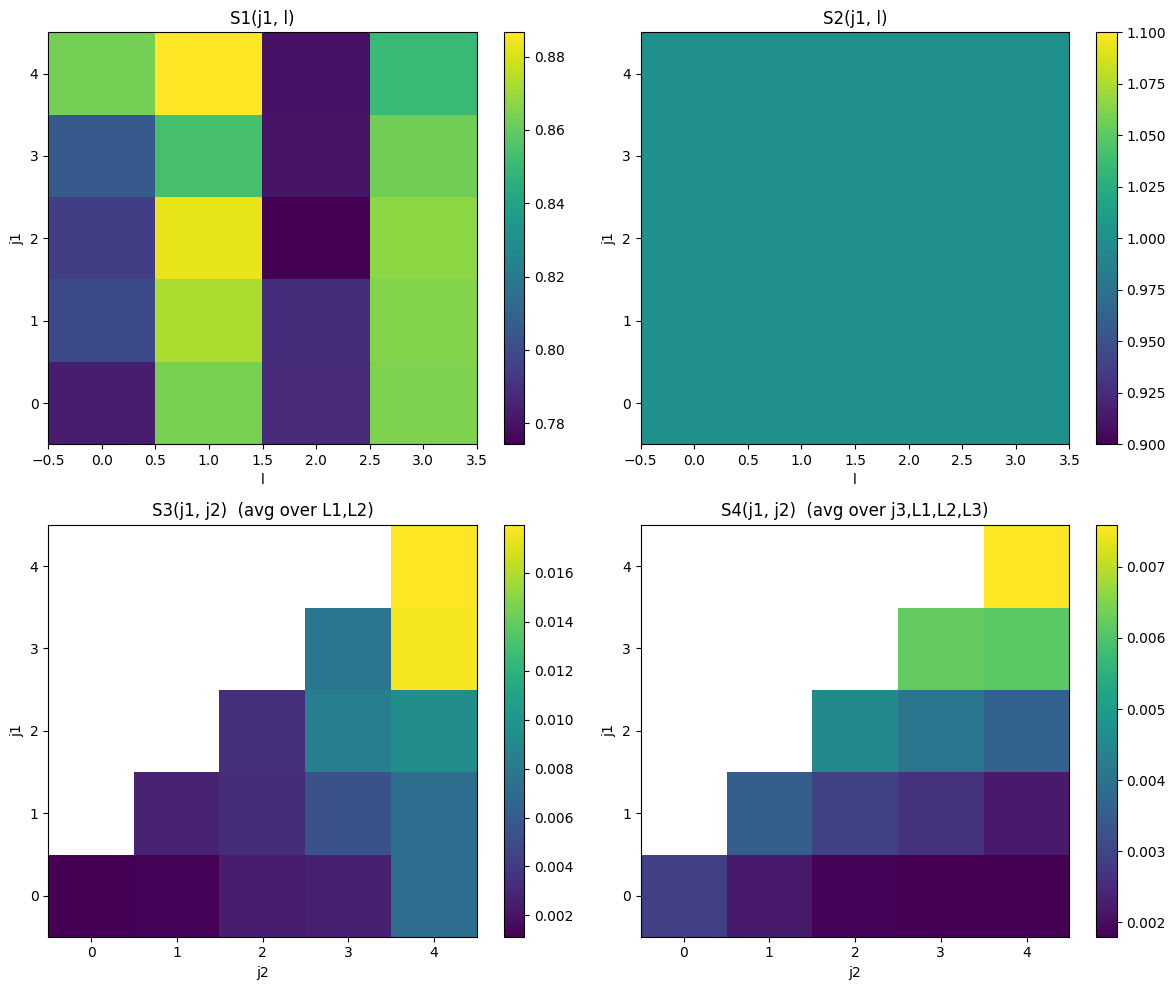

In [2]:
r.plot_coeff(b=0,c=0)

In [4]:
nside=64
import healpy as hp
from scipy.interpolate import RegularGridInterpolator

# convert the input data in a nside=128 healpix map
l_nside=128
try:
    im = np.load('target_map_lss.npy')
except:
    !wget -O target_map_lss.npy https://github.com/astro-informatics/s2scat/raw/main/notebooks/data/target_map_lss.npy
    im = np.load('target_map_lss.npy')
    
xsize,ysize=im.shape

# Define the new row and column to be added to prepare the interpolation
new_row = im[0:1,:]  # A new row with N elements (the other longitude)
new_column = np.concatenate([im[:,0:1],im[-2:-1,0:1]],0)  # A new column with N+1 elements to add previous latitude

# Add the new row to the array
im = np.vstack([im, new_row])

# Add the new column to the array with the new row

im = np.hstack([im, new_column])

# Create a grid of coordinates corresponding to the array indices
x = np.linspace(0, im.shape[0]-1, im.shape[0])
y = np.linspace(0, im.shape[1]-1, im.shape[1])

# Create an interpolator
interpolator = RegularGridInterpolator((x, y), im)

# List of healpix coordinate to interpol
colatitude,longitude = hp.pix2ang(l_nside,np.arange(12*l_nside**2),nest=True)
coords = np.concatenate([colatitude/np.pi*xsize,longitude/(2*np.pi)*ysize],0).reshape(2,colatitude.shape[0]).T

# Perform the interpolation
heal_im = interpolator(coords)

#reduce the final map to the expected resolution
if nside>128:
    th,ph=hp.pix2ang(nside,np.arange(12*nside**2),nest=True)
    heal_im=hp.get_interp_val(heal_im,th,ph,nest=True)
else:
    heal_im=np.mean(heal_im.reshape(12*nside**2,(l_nside//nside)**2),1)

# free memory
del coords
del interpolator
del colatitude
del longitude

In [5]:
from Synthesis import optimize_scattering_LBFGS

u_opt, histo = optimize_scattering_LBFGS(
    target=heal_im,
    STLDataClass=STLH,
    SO_class=SO,
    max_iter=50,
    lr=1,
    history_size=100,
    verbose=True,
)

Normalization of ScatCov statistics
Using self S2 for normalization
Normalization of ScatCov statistics
Using provided S2_ref for normalization


TypeError: sqrt(): argument 'input' (position 1) must be Tensor, not NoneType

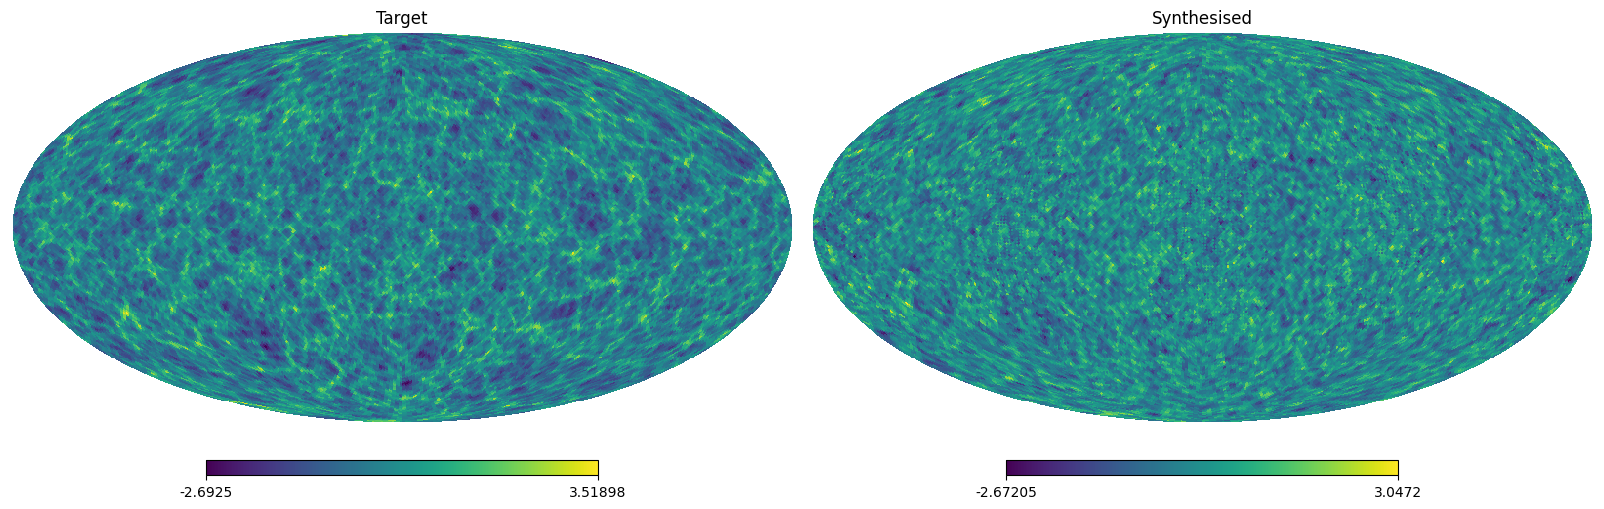

In [9]:
plt.figure(figsize=(16,7))
hp.mollview(heal_im,nest=True,hold=False,sub=(1,2,1),title='Target')
hp.mollview(u_opt.cpu().numpy(),nest=True,hold=False,sub=(1,2,2),title='Synthesised')

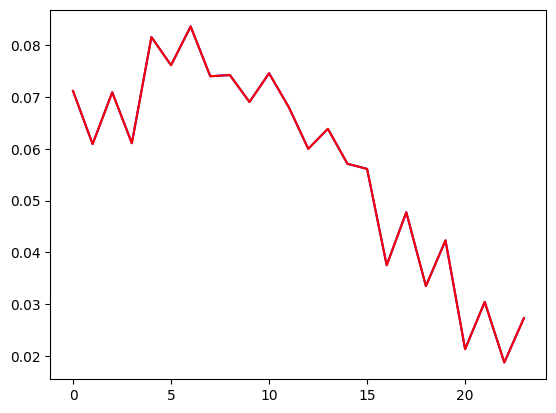

In [16]:
dc=STLH(heal_im)
st_op=SO(dc)
r=st_op.apply(dc)
dc=STLH(heal_im)
st_op=SO(dc)
rnorm=st_op.apply(dc,norm='auto')
#rnorm=st_op.apply(dc,norm='auto')

plt.plot(r.S1.flatten(),color='b')
plt.plot(rnorm.S1.flatten(),color='r')

In [ ]:

# Ensuite tu peux tracer histo pour voir la décroissance :
import matplotlib.pyplot as plt
plt.plot(histo)
plt.yscale("log")
plt.xlabel("LBFGS inner iteration")
plt.ylabel("Loss")
plt.show()

In [ ]:
import requests

url = "https://github.com/jmdelouis/FOSCAT/raw/main/src/tests/cloud_fields.npy"  # Lien brut
filename = "cloud_fields.npy"  # Nom du fichier local

# Télécharger le fichier
response = requests.get(url, stream=True)
if response.status_code == 200:
    with open(filename, "wb") as f:
        f.write(response.content)
    print(f"Fichier téléchargé : {filename}")
else:
    print(f"Échec du téléchargement, code HTTP : {response.status_code}")

image_target=np.load('cloud_fields.npy')[1]

plt.imshow(image_target,origin='lower')
target = np.log(image_target[None,None,:,:]+0.6)

In [ ]:
%%time

u_opt,histo = optimize_scattering_LBFGS(
    target=target,
    STLDataClass=STLDataClass,   # ta classe (ex: STL2DKernel)
    SO_class=SO,                 # ton opérateur de scattering
    max_iter=200,
    lr=1
)

In [ ]:
plt.imshow(np.exp(u_opt[0,0].cpu().numpy()-0.6))

In [ ]:
plt.plot(r.cpu().numpy(),color='b')
r_u=st_op.apply(STLDataClass(u_opt)).to_flatten()
plt.plot(r_u.to_flatten().cpu().numpy(),color='r')
plt.xscale('log')
plt.yscale('log')

In [ ]:
DC=STLH(np.random.randn(10,1,12*32**2),nside=32)
st_op=SO(DC)

r=st_op.apply(DC)

In [ ]:
import matplotlib.pyplot as plt
plt.subplot(2,2,1)
plt.plot(r.S1[0,0].cpu().numpy().flatten())
plt.subplot(2,2,2)
plt.plot(r.S2[0,0].cpu().numpy().flatten())
plt.subplot(2,2,3)
plt.plot(r.S3[0,0].cpu().numpy().flatten())
plt.subplot(2,2,4)
plt.plot(r.S4[0,0].cpu().numpy().flatten())

In [ ]:
wop=DC.get_wavelet_op()
w=wop.kernel[0]

In [ ]:
import matplotlib.pyplot as plt

for i in range(4):
    print(np.mean(w[i].cpu().numpy().real),np.mean(w[i].cpu().numpy().imag),np.sum(abs(w[i].cpu().numpy())))
    plt.subplot(3,4,1+i)
    plt.imshow(w[i].cpu().numpy().real)
    plt.xticks([])
    plt.yticks([])
    plt.subplot(3,4,5+i)
    plt.imshow(w[i].cpu().numpy().imag)
    plt.xticks([])
    plt.yticks([])
    plt.subplot(3,4,9+i)
    plt.imshow(abs(w[i].cpu().numpy()))
    plt.xticks([])
    plt.yticks([])

In [ ]:
r=wop.apply(DC,0).array

In [ ]:
for i in range(4):
    print(np.mean(w[i].cpu().numpy().real),np.mean(w[i].cpu().numpy().imag),np.sum(abs(w[i].cpu().numpy())))
    plt.subplot(3,4,1+i)
    plt.imshow(r[i].cpu().numpy().real)
    plt.xticks([])
    plt.yticks([])
    plt.subplot(3,4,5+i)
    plt.imshow(r[i].cpu().numpy().imag)
    plt.xticks([])
    plt.yticks([])
    plt.subplot(3,4,9+i)
    plt.imshow(abs(r[i].cpu().numpy()))
    plt.xticks([])
    plt.yticks([])

In [ ]:
LDC=DC.downsample(1,copy=True)
r=wop.apply(LDC,1).array
amp=1
for i in range(4):
    print(np.mean(w[i].cpu().numpy().real),np.mean(w[i].cpu().numpy().imag),np.sum(abs(w[i].cpu().numpy())))
    plt.subplot(3,4,1+i)
    plt.imshow(r[i].cpu().numpy().real,vmin=-amp,vmax=amp)
    plt.xticks([])
    plt.yticks([])
    plt.subplot(3,4,5+i)
    plt.imshow(r[i].cpu().numpy().imag,vmin=-amp,vmax=amp)
    plt.xticks([])
    plt.yticks([])
    plt.subplot(3,4,9+i)
    plt.imshow(abs(r[i].cpu().numpy()),vmin=0,vmax=amp)
    plt.xticks([])
    plt.yticks([])

In [ ]:
LDC=STLDataClass(np.random.randn(10,512,512))

amp=0.3

plt.figure(figsize=(16,16))
for j in range(5):
    r=wop.apply(LDC,j).array[0]
    for i in range(4):
        plt.subplot(5,4,1+4*j+i)
        plt.imshow(abs(r[i].cpu().numpy()),vmin=0,vmax=amp)
    plt.xticks([])
    plt.yticks([])
    
    LDC=LDC.downsample(j+1,copy=True)
    print(LDC.array.shape)